# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
#import ta

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import SCORERS


In [5]:
#from pandas_datareader import data as pdr
#import yfinance as yf
#yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

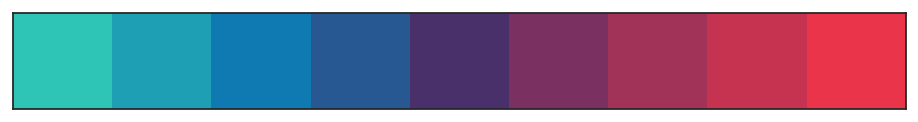

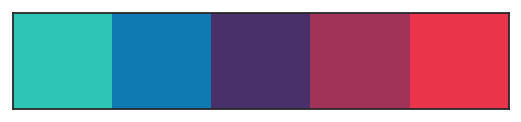

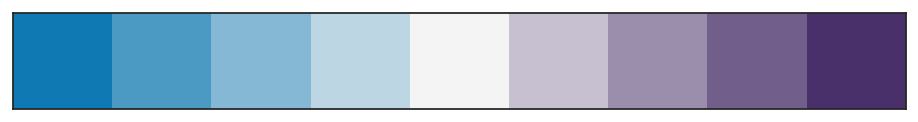

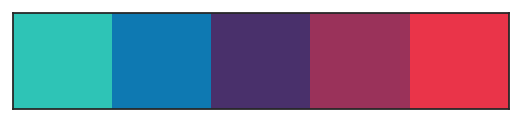

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [10]:
df_all = pd.read_csv(DATA_OUT_PATH + "merged_data.csv")
df_all.head(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2021-01-01,0.175350,0.184246,0.172022,0.181382,1.122218e+09,5.868556,6.506998,5.652401,6.490297,...,0.053993,0.051369,2.036519e+09,47.984858,-0.000144,0.001536,255658268.0,57.385950,-0.050738,0.191277
1,2021-01-02,0.177423,0.184253,0.169233,0.175359,1.408850e+09,5.414613,5.882211,5.319140,5.869282,...,0.053286,0.049277,2.053894e+09,53.344082,-0.000058,0.001609,223987204.0,55.832142,-0.027803,0.198930
2,2021-01-03,0.204995,0.208679,0.173376,0.177382,2.303858e+09,5.813898,5.900645,5.301713,5.416301,...,0.054555,0.049605,2.071803e+09,56.959753,0.000084,0.001614,279060626.0,64.577875,0.019398,0.235608


In [11]:
#Date to datetime
df_all.Date = pd.to_datetime(df_all.Date)
#Date as datetime index
df_all.set_index('Date', inplace=True)
#set freq as day
df_all = df_all.asfreq('D')
#sort date index
df_all = df_all.sort_index()

In [12]:
#filter to 2022
df_ = df_all.loc[df_all.index.year == 2022].copy()

#select target
target_col = 'btc_close'

#select exog var
exog = [i for i in df_all.columns.tolist() if i not in target_col]

#shift exog
X, y = df_[exog], df_[target_col]

#train as Jan-Mar
X_train, y_train = X.iloc[df_.index.month.isin([1,2,3])], y.iloc[df_.index.month.isin([1,2,3])]

#test as Apr, shift X by +1 for prediction (e.g. Apr 25's exog is Apr 24's)
X_test, y_test  = X.shift(periods=1, freq=None).iloc[df_.index.month == 4], y.iloc[df_.index.month == 4]

## Model Selection

### Set up pipeline

In [13]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
from skforecast.model_selection import grid_search_forecaster

In [14]:
model = XGBRegressor()

In [15]:
pipe = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    model)

In [16]:
forecaster = ForecasterAutoreg(
                regressor = pipe,
                lags = 10 #changes in gs_f
             )

# Regressor's hyperparameters
param_grid = {
    'selectkbest__k':[10, 20, 30],
    'xgbregressor__learning_rate': np.linspace(0.1, 1, 10)
}

# Lags used as predictors
lags_grid = [i for i in range(7, 13)]

gs_f = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = y_train,
                        exog        = X_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 1,
                        metric      = 'mean_absolute_percentage_error',
                        refit       = True,
                        initial_train_size = 7,
                        return_best = True,
                        verbose     = False,
                        fixed_train_size = True
                  )

Number of models compared: 180


loop lags_grid:   0%|                                               | 0/6 [00:00<?, ?it/s]

Forecaster will be fit 83 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



ValueError: Found array with 0 sample(s) (shape=(0, 110)) while a minimum of 1 is required by StandardScaler.

In [ ]:
forecaster.fit(y=y_train, exog=X_train)
forecaster

In [ ]:
results = forecaster.predict(steps=1, exog=y_test)
results